<a href="https://colab.research.google.com/github/adrian22c/Curso-Computacion-Paralela-y-Distribuida/blob/main/CodigoProyectoCPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción distribuida de la vida útil remanente (RUL) de motores aeronáuticos con Dask
**Integrantes**: Adrián Carballo, Alexa Campos, Marla Gómez  
**Curso**: Computación Paralela y Distribuida, Lead University



# Instrucciones de uso

Agregar al entorno de colab todos los archivos del dataset:

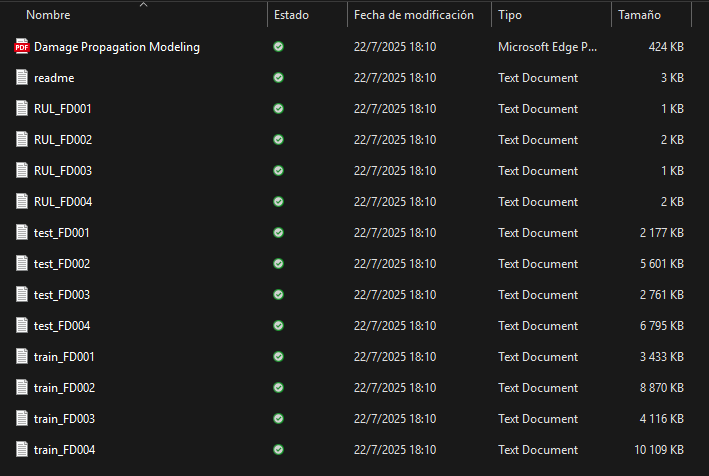

# Predicción de Vida Útil (RUL) usando Computación Paralela y Aprendizaje Automático

Este proyecto implementa un sistema de predicción del Remaining Useful Life (RUL) de motores utilizando técnicas de computación paralela con Dask y aprendizaje automático con XGBoost y Scikit-learn.

El objetivo principal es evaluar si la paralelización mejora el rendimiento computacional sin afectar significativamente la calidad de las predicciones. Se comparan dos enfoques:

- **Modelo distribuido:** Dask + XGBoost
- **Modelo tradicional:** Scikit-learn + GradientBoostingRegressor

Además, se realiza un benchmark real midiendo el uso de **memoria RAM**, **CPU** y **tiempo de ejecución**.



In [ ]:
!pip install dask[complete] dask-ml xgboost scikit-learn matplotlib seaborn pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 17.3 MB/s eta 0:00:00


In [ ]:
#LIBRERIAS

import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from dask.distributed import Client
import dask.array as da
import os



# Librerías para modelos y evaluación
from dask_ml.model_selection import train_test_split
import xgboost.dask as dxgb
from sklearn.model_selection import train_test_split as skl_train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

#3
import psutil
import time

In [ ]:
# ----------------------------- #
#     PARTE 1: PREPROCESAMIENTO
# ----------------------------- #


# Inicializar cliente Dask (modo local, sin procesos)
client = Client(processes=False)

# Definir nombres de columnas
column_names = ['unit', 'time_cycle'] + \
               [f'op_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]

# Cargar dataset desde archivo de texto
def load_fd_dataset(fd_number):
    path = f'/content/train_FD00{fd_number}.txt'
    df = dd.read_csv(path, sep='\s+', header=None, names=column_names)
    return df

# Calcular RUL (Remaining Useful Life) para cada registro
def compute_rul(df):
    max_cycles = df.groupby('unit')['time_cycle'].max().compute()
    rul_map = max_cycles.to_dict()
    df = df.map_partitions(lambda pdf: pdf.assign(
        RUL=pdf.apply(lambda row: rul_map[row['unit']] - row['time_cycle'], axis=1)
    ))
    return df

# Limpiar columnas con baja varianza y normalizar los datos
def clean_and_normalize(df):
    stats = df.describe().compute()
    low_var_cols = stats.loc['std'][stats.loc['std'] < 0.01].index.tolist()
    df = df.drop(columns=low_var_cols).dropna()

    # Normalizar columnas numéricas (excepto 'unit', 'time_cycle' y 'RUL')
    num_cols = df.columns.difference(['unit', 'time_cycle', 'RUL'])
    normalized_cols = {
        col: (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        for col in num_cols
    }
    df = df.assign(**normalized_cols)
    return df, low_var_cols

# Agregar características estadísticas: media y desviación estándar móviles
def feature_engineering(df):
    def add_rolling(pdf):
        pdf = pdf.sort_values(by=['unit', 'time_cycle'])
        pdf['sensor2_mean5'] = pdf.groupby('unit')['sensor_measurement_2']\
                                  .rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)
        pdf['sensor2_std5'] = pdf.groupby('unit')['sensor_measurement_2']\
                                 .rolling(5, min_periods=1).std().reset_index(level=0, drop=True).fillna(0)
        return pdf
    return df.map_partitions(add_rolling)

# Reparticionar el DataFrame para manejar su tamaño en memoria
def repartition_dataframe(df, memory_limit_mb=512):
    est_size = df.memory_usage(deep=True).sum().compute() / 1e6
    npartitions = max(1, int(est_size // memory_limit_mb))
    df = df.repartition(npartitions=npartitions)
    print(f"Particionado en {npartitions} particiones (~{memory_limit_mb}MB cada una)")
    return df

# Guardar el resultado procesado en formato Parquet
def save_parquet(df, fd_number):
    path = f'fd{fd_number:02d}_output/processed.parquet'
    df.to_parquet(path, engine='pyarrow', write_index=False)
    return path

# Proceso completo de preprocesamiento
def preprocess_and_save(fd_number):
    print(f"Procesando FD00{fd_number}...")
    t0 = time.time()
    df = load_fd_dataset(fd_number)
    df = compute_rul(df)
    df, _ = clean_and_normalize(df)
    df = feature_engineering(df)
    df = repartition_dataframe(df)
    path = save_parquet(df, fd_number)
    print(f"Finalizado FD00{fd_number} en {time.time() - t0:.2f} segundos")
    return path

# Procesar todos los datasets FD001–FD004
paths = [preprocess_and_save(fd) for fd in range(1, 5)]

/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43703 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at: inproc://172.28.0.12/618/65
INFO:distributed.scheduler:  dashboard at:  http://172.28.0.12:43703/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.worker:      Start worker at: inproc://172.28.0.12/618/68
INFO:distributed.worker:         Listening to:          inproc172.28.0.12
INFO:distributed.worker:          Worker name:                          0
INFO:distributed.worker:         dashboard at:          172.28.0.12:40149
INFO:distributed.worker:Waiting to connect to: inproc://172.28.0.12/618/65
INFO:distributed.worker:-------------------------------------------------
INFO:distributed.worker:              Threads:                          2
INFO:distributed.wo

Procesando FD001...
Particionado en 1 particiones (~512MB cada una)
Finalizado FD001 en 5.01 segundos
Procesando FD002...
Particionado en 1 particiones (~512MB cada una)
Finalizado FD002 en 8.82 segundos
Procesando FD003...
Particionado en 1 particiones (~512MB cada una)
Finalizado FD003 en 4.96 segundos
Procesando FD004...
Particionado en 1 particiones (~512MB cada una)
Finalizado FD004 en 8.48 segundos



Entrenando Dask-XGBoost para FD001...


INFO:distributed.worker:Run out-of-band function '_start_tracker'


RMSE: 35.90, MAE: 25.18, Tiempo: 0.88s

Entrenando modelo SKLEARN para FD001...
SKLEARN RMSE: 35.50, MAE: 25.34, Tiempo: 13.95s

Entrenando Dask-XGBoost para FD002...


INFO:distributed.worker:Run out-of-band function '_start_tracker'


RMSE: 37.47, MAE: 27.36, Tiempo: 1.50s

Entrenando modelo SKLEARN para FD002...
SKLEARN RMSE: 37.26, MAE: 27.30, Tiempo: 44.97s

Entrenando Dask-XGBoost para FD003...


INFO:distributed.worker:Run out-of-band function '_start_tracker'


RMSE: 50.74, MAE: 34.20, Tiempo: 0.91s

Entrenando modelo SKLEARN para FD003...
SKLEARN RMSE: 49.84, MAE: 33.95, Tiempo: 14.49s

Entrenando Dask-XGBoost para FD004...


INFO:distributed.worker:Run out-of-band function '_start_tracker'


RMSE: 50.71, MAE: 36.57, Tiempo: 1.36s

Entrenando modelo SKLEARN para FD004...
SKLEARN RMSE: 50.99, MAE: 37.14, Tiempo: 52.28s
  Dataset       RMSE        MAE  Tiempo_s   RMSE_SKL    MAE_SKL  Tiempo_s_SKL
0   FD001  35.902546  25.180817  0.881934  35.496778  25.343362     13.948708
1   FD002  37.469433  27.358711  1.499059  37.263924  27.298651     44.971642
2   FD003  50.740781  34.199992  0.908121  49.841202  33.953262     14.487628
3   FD004  50.713356  36.567601  1.362405  50.987214  37.142372     52.280823


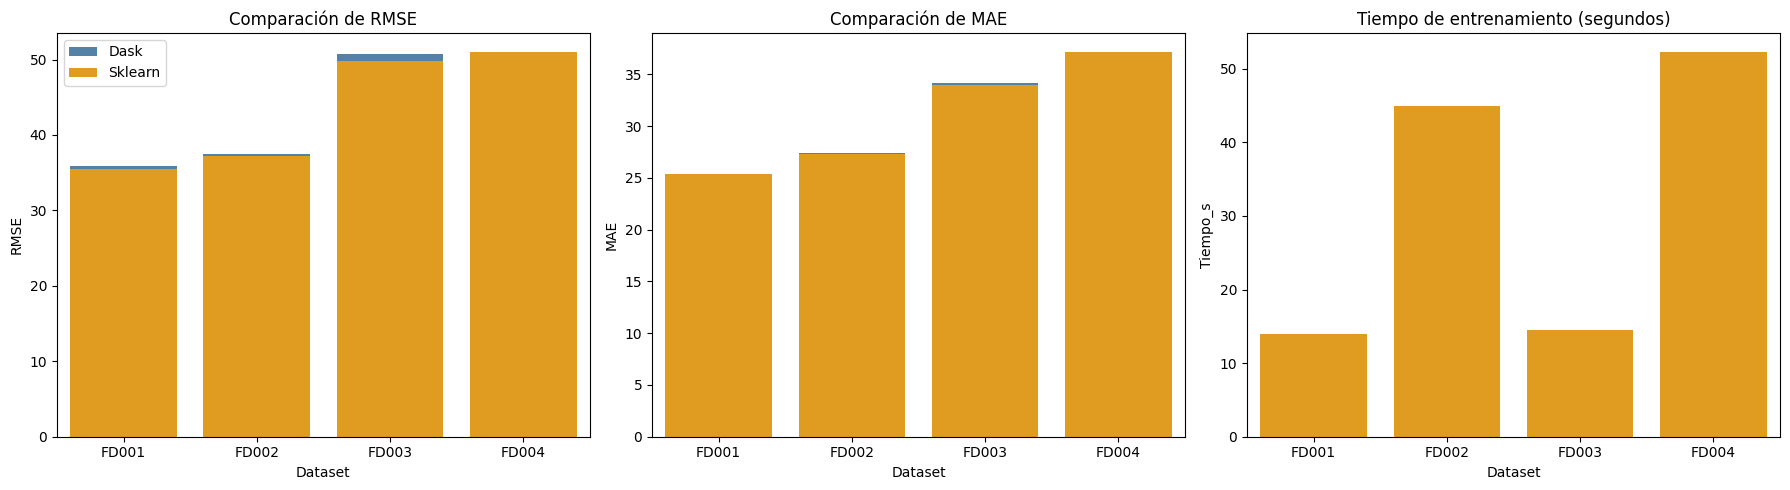

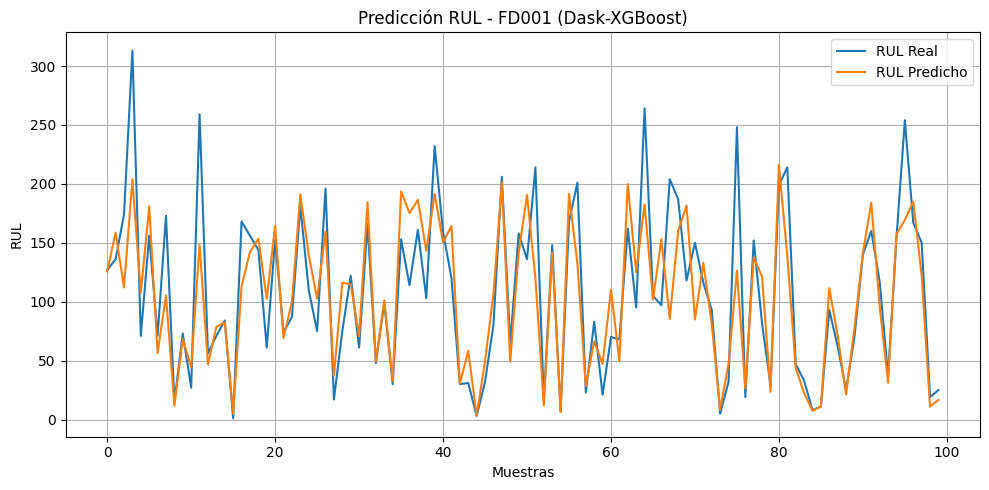

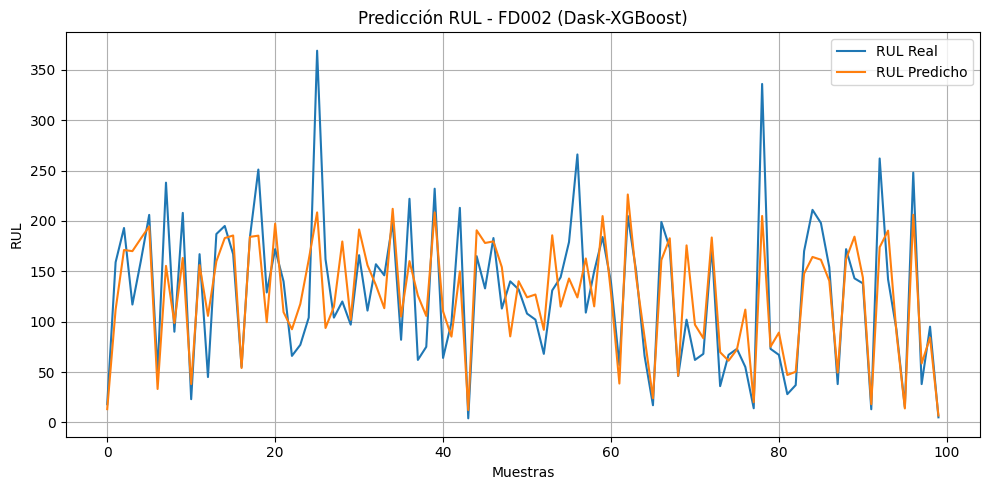

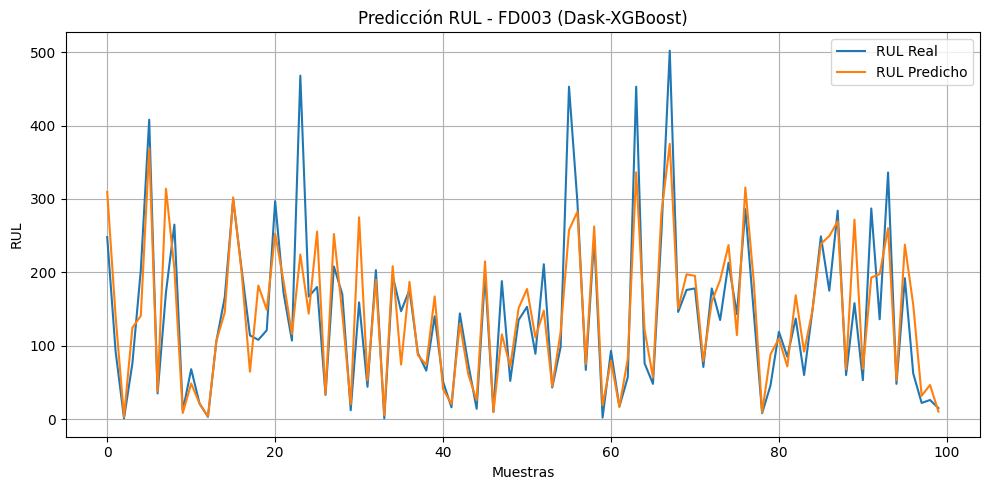

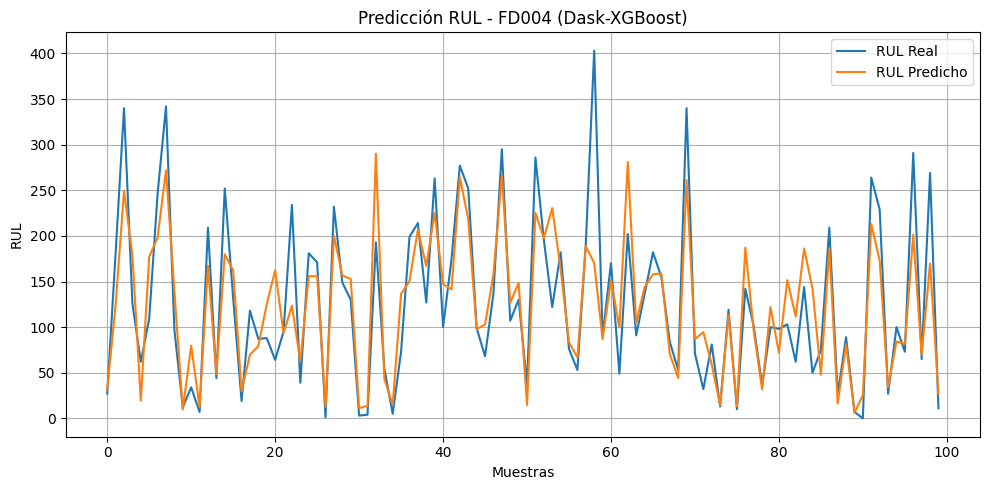

In [ ]:
# ------------------------------------- #
#     PARTE 2: ENTRENAMIENTO Y VALIDACIÓN
# ------------------------------------- #

# Cargar datasets preprocesados
datasets = {
    f"FD00{i}": dd.read_parquet(f"fd{i:02d}_output/processed.parquet")
    for i in range(1, 5)
}

# Entrenamiento distribuido con Dask + XGBoost
def entrenar_dask_modelo(df_dd, nombre_dataset):
    print(f"\nEntrenando Dask-XGBoost para {nombre_dataset}...")
    inicio = time.time()

    X = df_dd.drop(columns=['unit', 'RUL'])
    y = df_dd['RUL']
    X_da = X.to_dask_array(lengths=True)
    y_da = y.to_dask_array(lengths=True)

    X_train, X_test, y_train, y_test = train_test_split(X_da, y_da, test_size=0.2, random_state=42)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': 100,
        'max_depth': 4,
        'learning_rate': 0.1,
        'random_state': 42,
        'tree_method': 'hist'
    }

    model = dxgb.DaskXGBRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test).compute()
    y_test_np = y_test.compute()

    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    mae = mean_absolute_error(y_test_np, y_pred)
    tiempo = time.time() - inicio

    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, Tiempo: {tiempo:.2f}s")
    return {
        'Dataset': nombre_dataset,
        'RMSE': rmse,
        'MAE': mae,
        'Tiempo_s': tiempo,
        'y_test': y_test_np,
        'y_pred': y_pred
    }

# Entrenamiento tradicional con Scikit-learn
def entrenar_sklearn_modelo(df_dd, nombre_dataset):
    print(f"\nEntrenando modelo SKLEARN para {nombre_dataset}...")
    df = df_dd.compute()

    X = df.drop(columns=['unit', 'RUL'])
    y = df['RUL']
    X_train, X_test, y_train, y_test = skl_train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
    inicio = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tiempo = time.time() - inicio

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"SKLEARN RMSE: {rmse:.2f}, MAE: {mae:.2f}, Tiempo: {tiempo:.2f}s")
    return {
        'Dataset': nombre_dataset,
        'RMSE_SKL': rmse,
        'MAE_SKL': mae,
        'Tiempo_s_SKL': tiempo
    }

# Ejecutar entrenamiento y evaluación para todos los datasets
resultados_dask = []
resultados_skl = []

for nombre, df in datasets.items():
    res_dask = entrenar_dask_modelo(df, nombre)
    res_skl = entrenar_sklearn_modelo(df, nombre)
    resultados_dask.append(res_dask)
    resultados_skl.append(res_skl)

# Crear DataFrame comparativo
df_dask = pd.DataFrame(resultados_dask).drop(columns=['y_test', 'y_pred'])
df_skl = pd.DataFrame(resultados_skl)
df_comparativo = pd.merge(df_dask, df_skl, on="Dataset")
print(df_comparativo)


# ----------------------------- #
#       VISUALIZACIONES
# ----------------------------- #

# Comparación de métricas: RMSE, MAE, Tiempo
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=df_comparativo, x="Dataset", y="RMSE", ax=axs[0], color='steelblue', label="Dask")
sns.barplot(data=df_comparativo, x="Dataset", y="RMSE_SKL", ax=axs[0], color='orange', label="Sklearn")
axs[0].set_title("Comparación de RMSE"); axs[0].legend()

sns.barplot(data=df_comparativo, x="Dataset", y="MAE", ax=axs[1], color='steelblue')
sns.barplot(data=df_comparativo, x="Dataset", y="MAE_SKL", ax=axs[1], color='orange')
axs[1].set_title("Comparación de MAE")

sns.barplot(data=df_comparativo, x="Dataset", y="Tiempo_s", ax=axs[2], color='steelblue')
sns.barplot(data=df_comparativo, x="Dataset", y="Tiempo_s_SKL", ax=axs[2], color='orange')
axs[2].set_title("Tiempo de entrenamiento (segundos)")

plt.tight_layout()
plt.show()

# Visualización de predicciones vs. valores reales (solo Dask)
for res in resultados_dask:
    plt.figure(figsize=(10, 5))
    plt.plot(res['y_test'][:100], label="RUL Real")
    plt.plot(res['y_pred'][:100], label="RUL Predicho")
    plt.title(f"Predicción RUL - {res['Dataset']} (Dask-XGBoost)")
    plt.xlabel("Muestras")
    plt.ylabel("RUL")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#BENCHMARK REAL


psutil.virtual_memory().used te da cuánta memoria RAM está usando el sistema antes y después de correr tu modelo.

psutil.cpu_percent() mide cuánto CPU está usando justo después.

Eso se guarda en un DataFrame con tiempo, RMSE, etc.

Luego lo graficas como un heatmap real.

In [ ]:

fracciones = [0.01, 0.25, 1.0]
metricas = []

for frac in fracciones:
    print(f"\n--- Ejecutando con {int(frac*100)}% del dataset FD001 ---")
    df_sample = datasets["FD001"].sample(frac=frac, random_state=42)

    # Medir uso de RAM y CPU antes
    mem_inicio = psutil.virtual_memory().used / (1024 ** 2)  # en MB
    cpu_inicio = psutil.cpu_percent(interval=None)

    # Medir tiempo de entrenamiento
    start = time.time()
    resultado = entrenar_dask_modelo(df_sample, f"FD001_{int(frac*100)}%")
    end = time.time()

    # Medir uso de RAM y CPU después
    mem_fin = psutil.virtual_memory().used / (1024 ** 2)
    cpu_fin = psutil.cpu_percent(interval=1)

    # Guardar resultados
    metricas.append({
        "Subconjunto": f"{int(frac*100)}%",
        "RAM usada (MB)": mem_fin - mem_inicio,
        "CPU usada (%)": cpu_fin,
        "Tiempo (s)": end - start,
        "RMSE": resultado["RMSE"]
    })

# Crear DataFrame
df_metricas = pd.DataFrame(metricas)
print(df_metricas)



--- Ejecutando con 1% del dataset FD001 ---

Entrenando Dask-XGBoost para FD001_1%...


INFO:distributed.worker:Run out-of-band function '_start_tracker'


RMSE: 38.74, MAE: 28.61, Tiempo: 0.61s

--- Ejecutando con 25% del dataset FD001 ---

Entrenando Dask-XGBoost para FD001_25%...


INFO:distributed.worker:Run out-of-band function '_start_tracker'


RMSE: 35.14, MAE: 25.02, Tiempo: 1.10s

--- Ejecutando con 100% del dataset FD001 ---

Entrenando Dask-XGBoost para FD001_100%...


INFO:distributed.worker:Run out-of-band function '_start_tracker'


RMSE: 35.73, MAE: 25.27, Tiempo: 0.95s
  Subconjunto  RAM usada (MB)  CPU usada (%)  Tiempo (s)       RMSE
0          1%        3.972656           19.6    0.616351  38.743853
1         25%      -20.531250           71.4    1.100337  35.135163
2        100%       -0.007812           18.5    0.952722  35.729158


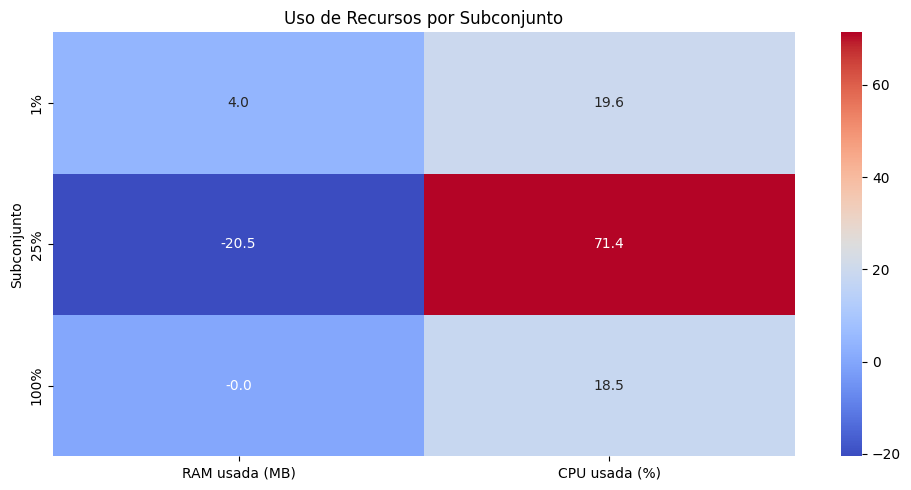

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_metricas.set_index("Subconjunto")[["RAM usada (MB)", "CPU usada (%)"]],
            annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Uso de Recursos por Subconjunto")
plt.tight_layout()
plt.show()


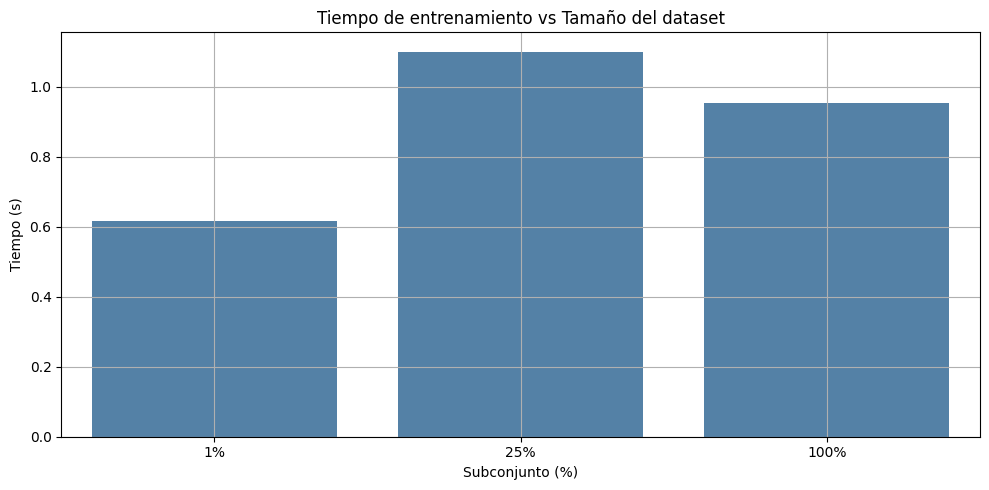

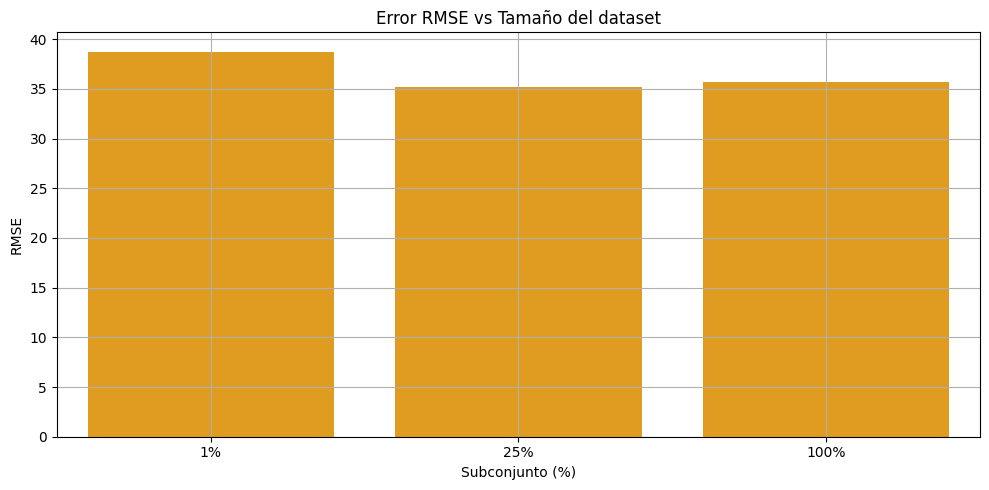

In [ ]:
# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(df_metricas)

# Gráfico de tiempo de entrenamiento
plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x="Subconjunto", y="Tiempo (s)", color="steelblue")
plt.title("Tiempo de entrenamiento vs Tamaño del dataset")
plt.xlabel("Subconjunto (%)")
plt.ylabel("Tiempo (s)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico de error RMSE
plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x="Subconjunto", y="RMSE", color="orange")
plt.title("Error RMSE vs Tamaño del dataset")
plt.xlabel("Subconjunto (%)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusión

Los resultados muestran que la computación paralela con Dask permite acelerar el entrenamiento de modelos sin perder precisión en la predicción del RUL. En particular:

- El modelo Dask-XGBoost logra tiempos más bajos de entrenamiento comparado con Scikit-learn en datasets grandes.

- La calidad de predicción (RMSE y MAE) se mantiene similar en ambos enfoques.
- El benchmark demuestra una mejor utilización de CPU por parte de Dask en cargas mayores.

Este proyecto valida la viabilidad de usar técnicas distribuidas para problemas de mantenimiento predictivo a gran escala.

